## TRAIN AND VALIDATION

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, fig_name, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, None, data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
#     ax_1.legend(loc=0)
    ax_1.grid('on') # Turn axes grid on
    ax_1.legend(loc='best', fontsize=11) # Add a legend
    ax_1.set_xlabel('Epoch number')

    fig_1.tight_layout() # This minimises whitespace around the axes.
    fig_1.savefig('err_' + fig_name) # Save figure to current directory in PDF format
    
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
#     ax_2.legend(loc=0)
    ax_2.grid('on') # Turn axes grid on
    ax_2.legend(loc='best', fontsize=11) # Add a legend
    ax_2.set_xlabel('Epoch number')
    
    fig_2.tight_layout() # This minimises whitespace around the axes.
    fig_2.savefig('acc_' + fig_name) # Save figure to current directory in PDF format
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

## TRAIN AND TEST

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def test_model(model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, test_data, None,data_monitors, notebook=notebook)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    
    return stats, keys, run_time

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
from itertools import product
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider

# Seed a random number generator
seed = 11102018 
rng = np.random.RandomState(seed)
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

In [3]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRule, RMSPropLearningRule, GradientDescentLearningRule, AdaGradLearningRule, AdamLearningRuleWithWeightDecay
from mlp.optimisers import Optimiser

### batch_size = 100

In [ ]:
# Set batch size
batch_size = 100

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

# RMSprop

In [ ]:
# setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

learning_rates = [0.000001, 0.0000015, 0.00001, 0.000015, 0.0001, 0.00015]  # scale for random parameter initialisation
decay_rates = np.linspace(0.1, 0.9, 5)
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for i, element in enumerate(product(learning_rates, decay_rates)):
    
    print('-' * 80)
    print('learning_rate={0:.2e}, decay_rate={1:.2e}'
          .format(element[0], element[1]))
    print('-' * 80)
    
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    # Create a model with three hidden layers
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = RMSPropLearningRule(learning_rate=element[0], beta=element[1])

    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, fig_name='RMSprop_' + str(i) + '.pdf', notebook=True)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
    print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

In [ ]:
j = 0
print('| batch_size | learning_rate | decay_rate | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|---------------|------------|--------------------|--------------------|------------------|------------------|')
for element in product(learning_rates, decay_rates):
    print('| {0}   | {1:2f}   | {2:.2e}   | {3:.2e}   | {4:.2e}   | {5:.2e}   |  {6:.2f}      | {7:.2f}       |'
          .format(j, batch_size, element[0], element[1], 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

# Adam

In [ ]:
# setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

learning_rates = [0.000001, 0.0000015, 0.00001, 0.000015]  # scale for random parameter initialisation
decay_rates_1 = [0.85, 0.9, 0.95]
decay_rates_2 = [0.95, 0.975, 0.999]
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for i, element in enumerate(product(learning_rates, decay_rates_1, decay_rates_2)):
    
    print('-' * 80)
    print('learning_rate={0:.2e}, decay_rate={1:.2e}'
          .format(element[0], element[1]))
    print('-' * 80)
    
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    # Create a model with three hidden layers
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule(learning_rate=element[0], beta_1=element[1], beta_2=element[2])

    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, fig_name='Adam_' + str(i) + '.pdf', notebook=True)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
    print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

In [ ]:
j = 0
print('| batch_size | learning_rate | dr_1 | dr_2 | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|---------------|------|------|--------------------|--------------------|------------------|------------------|')
for element in product(learning_rates, decay_rates_1, decay_rates_2):
    print('| {0}   | {1:2f}   | {2:.2e}   | {3:.2e}   | {4:.2e}   | {5:.2e}   | {6:.2e}    | {7:.2f}      | {8:.2f}       |'
          .format(j, batch_size, element[0], element[1], element[2], 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

### Aditional training on Adam

In [ ]:
# setup hyperparameters
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100

learning_rates = [0.000001, 0.0000015, 0.00001, 0.000015]  # scale for random parameter initialisation
decay_rates_1 = [0.99]#[0.85, 0.9, 0.95]
decay_rates_2 = [0.999]#[0.95, 0.975, 0.999]
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for i, element in enumerate(product(learning_rates, decay_rates_1, decay_rates_2)):
    
    print('-' * 80)
    print('learning_rate={0:.2e}, decay_rate={1:.2e}'
          .format(element[0], element[1]))
    print('-' * 80)
    
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    # Create a model with three hidden layers
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule(learning_rate=element[0], beta_1=element[1], beta_2=element[2])

    # Remember to use notebook=False when you write a script to be run in a terminal
    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, fig_name='Adam_' + str(i) + '.pdf', notebook=True)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
    print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

In [ ]:
j = 0
print('| batch_size | learning_rate | dr_1 | dr_2 | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|---------------|------|------|--------------------|--------------------|------------------|------------------|')
for element in product(learning_rates, decay_rates_1, decay_rates_2):
    print('| {0}   | {1:2f}   | {2:.2e}   | {3:.2e}   | {4:.2e}   | {5:.2e}   | {6:.2e}    | {7:.2f}      | {8:.2f}       |'
          .format(j, batch_size, element[0], element[1], element[2], 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

## Adam With Weight Decay

In [ ]:
#setup hyperparameters
learning_rate = 0.000015
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100


print('-' * 80)
print('learning_rate={0:.2e}'
      .format(learning_rate))
print('-' * 80)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with three hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRuleWithWeightDecay(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, fig_name='AdamWD_three_hidden_layers.pdf', notebook=True)

plt.show()

print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

# final_errors_train.append(stats[-1, keys['error(train)']])
# final_errors_valid.append(stats[-1, keys['error(valid)']])
# final_accs_train.append(stats[-1, keys['acc(train)']])
# final_accs_valid.append(stats[-1, keys['acc(valid)']])

## TEST ALL THREE MODELS

### batch_size = 100

In [4]:
# Set batch size
batch_size = 100

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

KeysView(<numpy.lib.npyio.NpzFile object at 0x106588c88>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x10665de10>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x106588c88>)


### SGD

In [5]:
#setup hyperparameters
learning_rate = 0.01
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100


print('-' * 80)
print('learning_rate={0:.2e}'
      .format(learning_rate))
print('-' * 80)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
test_data.reset()

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with three hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
stats_1, keys_1, run_time_1 = test_model(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

print('    final error(train) = {0:.2e}'.format(stats_1[-1, keys_1['error(train)']]))
print('    final error(test)  = {0:.2e}'.format(stats_1[-1, keys_1['error(valid)']]))
print('    final acc(train)   = {0:.2e}'.format(stats_1[-1, keys_1['acc(train)']]))
print('    final acc(test)    = {0:.2e}'.format(stats_1[-1, keys_1['acc(valid)']]))
print('    run time per epoch = {0:.2f}'.format(run_time_1 * 1. / num_epochs))

--------------------------------------------------------------------------------
learning_rate=1.00e-02
--------------------------------------------------------------------------------


Epoch 1: 7.8s to complete
    error(train)=2.31e+00, acc(train)=4.09e-01, error(valid)=2.33e+00, acc(valid)=3.99e-01


Epoch 2: 6.7s to complete
    error(train)=1.53e+00, acc(train)=5.73e-01, error(valid)=1.56e+00, acc(valid)=5.64e-01


Epoch 3: 7.0s to complete
    error(train)=1.31e+00, acc(train)=6.26e-01, error(valid)=1.34e+00, acc(valid)=6.15e-01


Epoch 4: 6.7s to complete
    error(train)=1.17e+00, acc(train)=6.69e-01, error(valid)=1.20e+00, acc(valid)=6.61e-01


Epoch 5: 4.4s to complete
    error(train)=1.08e+00, acc(train)=6.85e-01, error(valid)=1.12e+00, acc(valid)=6.72e-01


Epoch 6: 4.5s to complete
    error(train)=1.01e+00, acc(train)=7.08e-01, error(valid)=1.04e+00, acc(valid)=6.97e-01


Epoch 7: 5.6s to complete
    error(train)=9.40e-01, acc(train)=7.27e-01, error(valid)=9.79e-01, acc(valid)=7.14e-01


Epoch 8: 4.4s to complete
    error(train)=8.96e-01, acc(train)=7.38e-01, error(valid)=9.35e-01, acc(valid)=7.24e-01


Epoch 9: 4.5s to complete
    error(train)=8.50e-01, acc(train)=7.49e-01, error(valid)=8.92e-01, acc(valid)=7.35e-01


Epoch 10: 4.5s to complete
    error(train)=8.20e-01, acc(train)=7.57e-01, error(valid)=8.66e-01, acc(valid)=7.43e-01


Epoch 11: 4.4s to complete
    error(train)=7.81e-01, acc(train)=7.67e-01, error(valid)=8.29e-01, acc(valid)=7.50e-01


Epoch 12: 5.5s to complete
    error(train)=7.47e-01, acc(train)=7.77e-01, error(valid)=7.99e-01, acc(valid)=7.57e-01


Epoch 13: 4.0s to complete
    error(train)=7.29e-01, acc(train)=7.77e-01, error(valid)=7.82e-01, acc(valid)=7.60e-01


Epoch 14: 4.0s to complete
    error(train)=7.04e-01, acc(train)=7.86e-01, error(valid)=7.58e-01, acc(valid)=7.68e-01


Epoch 15: 4.1s to complete
    error(train)=6.85e-01, acc(train)=7.90e-01, error(valid)=7.42e-01, acc(valid)=7.71e-01


Epoch 16: 7.0s to complete
    error(train)=6.71e-01, acc(train)=7.91e-01, error(valid)=7.28e-01, acc(valid)=7.73e-01


Epoch 17: 6.3s to complete
    error(train)=6.53e-01, acc(train)=7.99e-01, error(valid)=7.15e-01, acc(valid)=7.81e-01


Epoch 18: 4.2s to complete
    error(train)=6.43e-01, acc(train)=7.99e-01, error(valid)=7.08e-01, acc(valid)=7.80e-01


Epoch 19: 4.4s to complete
    error(train)=6.22e-01, acc(train)=8.07e-01, error(valid)=6.86e-01, acc(valid)=7.86e-01


Epoch 20: 4.7s to complete
    error(train)=6.11e-01, acc(train)=8.10e-01, error(valid)=6.80e-01, acc(valid)=7.88e-01


Epoch 21: 4.4s to complete
    error(train)=6.03e-01, acc(train)=8.10e-01, error(valid)=6.71e-01, acc(valid)=7.89e-01


Epoch 22: 4.5s to complete
    error(train)=5.87e-01, acc(train)=8.13e-01, error(valid)=6.62e-01, acc(valid)=7.92e-01


Epoch 23: 4.7s to complete
    error(train)=5.83e-01, acc(train)=8.15e-01, error(valid)=6.59e-01, acc(valid)=7.92e-01


Epoch 24: 4.7s to complete
    error(train)=5.67e-01, acc(train)=8.21e-01, error(valid)=6.46e-01, acc(valid)=7.98e-01


Epoch 25: 4.3s to complete
    error(train)=5.68e-01, acc(train)=8.16e-01, error(valid)=6.43e-01, acc(valid)=7.94e-01


Epoch 26: 8.3s to complete
    error(train)=5.51e-01, acc(train)=8.24e-01, error(valid)=6.34e-01, acc(valid)=8.00e-01


Epoch 27: 5.9s to complete
    error(train)=5.41e-01, acc(train)=8.28e-01, error(valid)=6.28e-01, acc(valid)=8.02e-01


Epoch 28: 4.7s to complete
    error(train)=5.35e-01, acc(train)=8.27e-01, error(valid)=6.20e-01, acc(valid)=8.02e-01


Epoch 29: 4.6s to complete
    error(train)=5.27e-01, acc(train)=8.29e-01, error(valid)=6.18e-01, acc(valid)=8.01e-01


Epoch 30: 6.9s to complete
    error(train)=5.35e-01, acc(train)=8.28e-01, error(valid)=6.25e-01, acc(valid)=8.00e-01


Epoch 31: 9.3s to complete
    error(train)=5.12e-01, acc(train)=8.35e-01, error(valid)=6.04e-01, acc(valid)=8.07e-01


Epoch 32: 5.3s to complete
    error(train)=5.08e-01, acc(train)=8.36e-01, error(valid)=6.04e-01, acc(valid)=8.08e-01


Epoch 33: 4.8s to complete
    error(train)=5.04e-01, acc(train)=8.36e-01, error(valid)=6.01e-01, acc(valid)=8.10e-01


Epoch 34: 4.7s to complete
    error(train)=4.95e-01, acc(train)=8.39e-01, error(valid)=5.93e-01, acc(valid)=8.11e-01


Epoch 35: 7.7s to complete
    error(train)=4.91e-01, acc(train)=8.39e-01, error(valid)=5.90e-01, acc(valid)=8.11e-01


Epoch 36: 4.9s to complete
    error(train)=4.86e-01, acc(train)=8.42e-01, error(valid)=5.92e-01, acc(valid)=8.12e-01


Epoch 37: 5.5s to complete
    error(train)=4.83e-01, acc(train)=8.42e-01, error(valid)=5.92e-01, acc(valid)=8.11e-01


Epoch 38: 14.9s to complete
    error(train)=4.86e-01, acc(train)=8.41e-01, error(valid)=5.94e-01, acc(valid)=8.09e-01


Epoch 39: 5.5s to complete
    error(train)=4.71e-01, acc(train)=8.45e-01, error(valid)=5.82e-01, acc(valid)=8.15e-01


Epoch 40: 5.8s to complete
    error(train)=4.69e-01, acc(train)=8.46e-01, error(valid)=5.82e-01, acc(valid)=8.16e-01


Epoch 41: 5.8s to complete
    error(train)=4.63e-01, acc(train)=8.47e-01, error(valid)=5.75e-01, acc(valid)=8.16e-01


Epoch 42: 5.7s to complete
    error(train)=4.57e-01, acc(train)=8.51e-01, error(valid)=5.71e-01, acc(valid)=8.16e-01


Epoch 43: 36.6s to complete
    error(train)=4.64e-01, acc(train)=8.48e-01, error(valid)=5.83e-01, acc(valid)=8.18e-01


Epoch 44: 32.8s to complete
    error(train)=4.47e-01, acc(train)=8.53e-01, error(valid)=5.64e-01, acc(valid)=8.20e-01


Epoch 45: 31.8s to complete
    error(train)=4.46e-01, acc(train)=8.53e-01, error(valid)=5.69e-01, acc(valid)=8.17e-01


Epoch 46: 34.7s to complete
    error(train)=4.44e-01, acc(train)=8.54e-01, error(valid)=5.64e-01, acc(valid)=8.19e-01


Epoch 47: 14.0s to complete
    error(train)=4.53e-01, acc(train)=8.49e-01, error(valid)=5.77e-01, acc(valid)=8.16e-01


Epoch 48: 4.9s to complete
    error(train)=4.38e-01, acc(train)=8.53e-01, error(valid)=5.67e-01, acc(valid)=8.16e-01


Epoch 49: 4.3s to complete
    error(train)=4.26e-01, acc(train)=8.59e-01, error(valid)=5.55e-01, acc(valid)=8.21e-01


Epoch 50: 4.3s to complete
    error(train)=4.30e-01, acc(train)=8.57e-01, error(valid)=5.60e-01, acc(valid)=8.21e-01


Epoch 51: 4.3s to complete
    error(train)=4.24e-01, acc(train)=8.59e-01, error(valid)=5.56e-01, acc(valid)=8.21e-01


Epoch 52: 3.9s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=5.55e-01, acc(valid)=8.21e-01


Epoch 53: 3.8s to complete
    error(train)=4.18e-01, acc(train)=8.61e-01, error(valid)=5.54e-01, acc(valid)=8.22e-01


Epoch 54: 8.2s to complete
    error(train)=4.16e-01, acc(train)=8.62e-01, error(valid)=5.54e-01, acc(valid)=8.23e-01


Epoch 55: 9.5s to complete
    error(train)=4.12e-01, acc(train)=8.62e-01, error(valid)=5.53e-01, acc(valid)=8.24e-01


Epoch 56: 4.8s to complete
    error(train)=4.10e-01, acc(train)=8.61e-01, error(valid)=5.50e-01, acc(valid)=8.21e-01


Epoch 57: 4.8s to complete
    error(train)=4.10e-01, acc(train)=8.63e-01, error(valid)=5.53e-01, acc(valid)=8.21e-01


Epoch 58: 4.9s to complete
    error(train)=4.02e-01, acc(train)=8.65e-01, error(valid)=5.46e-01, acc(valid)=8.23e-01


Epoch 59: 10.4s to complete
    error(train)=4.01e-01, acc(train)=8.65e-01, error(valid)=5.48e-01, acc(valid)=8.23e-01


Epoch 60: 7.9s to complete
    error(train)=4.04e-01, acc(train)=8.64e-01, error(valid)=5.51e-01, acc(valid)=8.23e-01


Epoch 61: 4.5s to complete
    error(train)=3.94e-01, acc(train)=8.68e-01, error(valid)=5.43e-01, acc(valid)=8.26e-01


Epoch 62: 4.2s to complete
    error(train)=3.95e-01, acc(train)=8.66e-01, error(valid)=5.44e-01, acc(valid)=8.26e-01


Epoch 63: 4.4s to complete
    error(train)=3.90e-01, acc(train)=8.68e-01, error(valid)=5.44e-01, acc(valid)=8.24e-01


Epoch 64: 5.5s to complete
    error(train)=3.89e-01, acc(train)=8.68e-01, error(valid)=5.46e-01, acc(valid)=8.24e-01


Epoch 65: 6.6s to complete
    error(train)=3.88e-01, acc(train)=8.70e-01, error(valid)=5.45e-01, acc(valid)=8.25e-01


Epoch 66: 5.5s to complete
    error(train)=3.85e-01, acc(train)=8.70e-01, error(valid)=5.43e-01, acc(valid)=8.26e-01


Epoch 67: 5.6s to complete
    error(train)=3.78e-01, acc(train)=8.72e-01, error(valid)=5.38e-01, acc(valid)=8.26e-01


Epoch 68: 5.7s to complete
    error(train)=3.78e-01, acc(train)=8.72e-01, error(valid)=5.37e-01, acc(valid)=8.27e-01


Epoch 69: 4.6s to complete
    error(train)=3.84e-01, acc(train)=8.66e-01, error(valid)=5.45e-01, acc(valid)=8.23e-01


Epoch 70: 4.8s to complete
    error(train)=3.79e-01, acc(train)=8.70e-01, error(valid)=5.45e-01, acc(valid)=8.25e-01


Epoch 71: 4.2s to complete
    error(train)=3.70e-01, acc(train)=8.74e-01, error(valid)=5.38e-01, acc(valid)=8.28e-01


Epoch 72: 4.3s to complete
    error(train)=3.71e-01, acc(train)=8.74e-01, error(valid)=5.43e-01, acc(valid)=8.27e-01


Epoch 73: 4.9s to complete
    error(train)=3.71e-01, acc(train)=8.73e-01, error(valid)=5.43e-01, acc(valid)=8.24e-01


Epoch 74: 6.6s to complete
    error(train)=3.70e-01, acc(train)=8.74e-01, error(valid)=5.44e-01, acc(valid)=8.26e-01


Epoch 75: 6.5s to complete
    error(train)=3.67e-01, acc(train)=8.74e-01, error(valid)=5.41e-01, acc(valid)=8.29e-01


Epoch 76: 5.2s to complete
    error(train)=3.64e-01, acc(train)=8.76e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


Epoch 77: 7.0s to complete
    error(train)=3.63e-01, acc(train)=8.75e-01, error(valid)=5.37e-01, acc(valid)=8.26e-01


Epoch 78: 6.0s to complete
    error(train)=3.61e-01, acc(train)=8.77e-01, error(valid)=5.45e-01, acc(valid)=8.26e-01


Epoch 79: 5.0s to complete
    error(train)=3.66e-01, acc(train)=8.72e-01, error(valid)=5.52e-01, acc(valid)=8.23e-01


Epoch 80: 4.3s to complete
    error(train)=3.54e-01, acc(train)=8.77e-01, error(valid)=5.37e-01, acc(valid)=8.27e-01


Epoch 81: 4.8s to complete
    error(train)=3.56e-01, acc(train)=8.77e-01, error(valid)=5.43e-01, acc(valid)=8.26e-01


Epoch 82: 4.2s to complete
    error(train)=3.53e-01, acc(train)=8.77e-01, error(valid)=5.36e-01, acc(valid)=8.29e-01


Epoch 83: 4.2s to complete
    error(train)=3.62e-01, acc(train)=8.74e-01, error(valid)=5.53e-01, acc(valid)=8.24e-01


Epoch 84: 4.4s to complete
    error(train)=3.48e-01, acc(train)=8.81e-01, error(valid)=5.37e-01, acc(valid)=8.28e-01


Epoch 85: 4.5s to complete
    error(train)=3.55e-01, acc(train)=8.76e-01, error(valid)=5.44e-01, acc(valid)=8.26e-01


Epoch 86: 4.6s to complete
    error(train)=3.44e-01, acc(train)=8.80e-01, error(valid)=5.35e-01, acc(valid)=8.28e-01


Epoch 87: 4.2s to complete
    error(train)=3.44e-01, acc(train)=8.80e-01, error(valid)=5.40e-01, acc(valid)=8.28e-01


Epoch 88: 4.3s to complete
    error(train)=3.43e-01, acc(train)=8.81e-01, error(valid)=5.37e-01, acc(valid)=8.30e-01


Epoch 89: 3.9s to complete
    error(train)=3.37e-01, acc(train)=8.84e-01, error(valid)=5.35e-01, acc(valid)=8.28e-01


Epoch 90: 4.2s to complete
    error(train)=3.46e-01, acc(train)=8.78e-01, error(valid)=5.47e-01, acc(valid)=8.24e-01


Epoch 91: 4.0s to complete
    error(train)=3.38e-01, acc(train)=8.83e-01, error(valid)=5.40e-01, acc(valid)=8.29e-01


Epoch 92: 5.5s to complete
    error(train)=3.36e-01, acc(train)=8.84e-01, error(valid)=5.37e-01, acc(valid)=8.30e-01


Epoch 93: 5.3s to complete
    error(train)=3.34e-01, acc(train)=8.84e-01, error(valid)=5.37e-01, acc(valid)=8.28e-01


Epoch 94: 6.6s to complete
    error(train)=3.34e-01, acc(train)=8.84e-01, error(valid)=5.41e-01, acc(valid)=8.28e-01


Epoch 95: 5.5s to complete
    error(train)=3.34e-01, acc(train)=8.84e-01, error(valid)=5.44e-01, acc(valid)=8.28e-01


Epoch 96: 5.4s to complete
    error(train)=3.30e-01, acc(train)=8.85e-01, error(valid)=5.38e-01, acc(valid)=8.31e-01


Epoch 97: 37.8s to complete
    error(train)=3.27e-01, acc(train)=8.86e-01, error(valid)=5.38e-01, acc(valid)=8.32e-01


Epoch 98: 38.1s to complete
    error(train)=3.23e-01, acc(train)=8.88e-01, error(valid)=5.35e-01, acc(valid)=8.32e-01


Epoch 99: 32.3s to complete
    error(train)=3.23e-01, acc(train)=8.87e-01, error(valid)=5.37e-01, acc(valid)=8.30e-01


Epoch 100: 19.6s to complete
    error(train)=3.22e-01, acc(train)=8.87e-01, error(valid)=5.39e-01, acc(valid)=8.30e-01



    final error(train) = 3.22e-01
    final error(test)  = 5.39e-01
    final acc(train)   = 8.87e-01
    final acc(test)    = 8.30e-01
    run time per epoch = 11.07


### RMSprop

In [6]:
#setup hyperparameters
learning_rate = 0.00001
decay_rate = 0.9
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100


print('-' * 80)
print('learning_rate={0:.2e}, decay_rate={1:.2e}'
      .format(learning_rate, decay_rate))
print('-' * 80)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with three hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
# learning_rule = RMSPropLearningRule()
learning_rule = RMSPropLearningRule(learning_rate=learning_rate, beta=decay_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
stats_2, keys_2, run_time_2 = test_model(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

print('    final error(train) = {0:.2e}'.format(stats_2[-1, keys_2['error(train)']]))
print('    final error(test)  = {0:.2e}'.format(stats_2[-1, keys_2['error(valid)']]))
print('    final acc(train)   = {0:.2e}'.format(stats_2[-1, keys_2['acc(train)']]))
print('    final acc(test)    = {0:.2e}'.format(stats_2[-1, keys_2['acc(valid)']]))
print('    run time per epoch = {0:.2f}'.format(run_time_2 * 1. / num_epochs))

--------------------------------------------------------------------------------
learning_rate=1.00e-05, decay_rate=9.00e-01
--------------------------------------------------------------------------------


Epoch 1: 8.2s to complete
    error(train)=3.10e+00, acc(train)=2.73e-01, error(valid)=3.12e+00, acc(valid)=2.68e-01


Epoch 2: 7.1s to complete
    error(train)=2.24e+00, acc(train)=4.47e-01, error(valid)=2.26e+00, acc(valid)=4.40e-01


Epoch 3: 6.1s to complete
    error(train)=1.82e+00, acc(train)=5.23e-01, error(valid)=1.84e+00, acc(valid)=5.17e-01


Epoch 4: 7.6s to complete
    error(train)=1.60e+00, acc(train)=5.71e-01, error(valid)=1.63e+00, acc(valid)=5.64e-01


Epoch 5: 7.8s to complete
    error(train)=1.47e+00, acc(train)=6.01e-01, error(valid)=1.49e+00, acc(valid)=5.92e-01


Epoch 6: 13.4s to complete
    error(train)=1.37e+00, acc(train)=6.21e-01, error(valid)=1.40e+00, acc(valid)=6.12e-01


Epoch 7: 5.9s to complete
    error(train)=1.31e+00, acc(train)=6.38e-01, error(valid)=1.34e+00, acc(valid)=6.27e-01


Epoch 8: 6.7s to complete
    error(train)=1.25e+00, acc(train)=6.52e-01, error(valid)=1.28e+00, acc(valid)=6.43e-01


Epoch 9: 7.4s to complete
    error(train)=1.21e+00, acc(train)=6.63e-01, error(valid)=1.24e+00, acc(valid)=6.53e-01


Epoch 10: 12.1s to complete
    error(train)=1.17e+00, acc(train)=6.71e-01, error(valid)=1.20e+00, acc(valid)=6.58e-01


Epoch 11: 6.4s to complete
    error(train)=1.14e+00, acc(train)=6.81e-01, error(valid)=1.17e+00, acc(valid)=6.68e-01


Epoch 12: 7.5s to complete
    error(train)=1.10e+00, acc(train)=6.88e-01, error(valid)=1.14e+00, acc(valid)=6.74e-01


Epoch 13: 5.8s to complete
    error(train)=1.08e+00, acc(train)=6.97e-01, error(valid)=1.11e+00, acc(valid)=6.81e-01


Epoch 14: 6.4s to complete
    error(train)=1.05e+00, acc(train)=7.01e-01, error(valid)=1.09e+00, acc(valid)=6.86e-01


Epoch 15: 12.9s to complete
    error(train)=1.03e+00, acc(train)=7.07e-01, error(valid)=1.07e+00, acc(valid)=6.91e-01


Epoch 16: 7.8s to complete
    error(train)=1.01e+00, acc(train)=7.13e-01, error(valid)=1.04e+00, acc(valid)=6.97e-01


Epoch 17: 9.7s to complete
    error(train)=9.89e-01, acc(train)=7.18e-01, error(valid)=1.03e+00, acc(valid)=7.01e-01


Epoch 18: 8.1s to complete
    error(train)=9.69e-01, acc(train)=7.23e-01, error(valid)=1.01e+00, acc(valid)=7.05e-01


Epoch 19: 12.0s to complete
    error(train)=9.54e-01, acc(train)=7.26e-01, error(valid)=9.92e-01, acc(valid)=7.08e-01


Epoch 20: 20.3s to complete
    error(train)=9.35e-01, acc(train)=7.31e-01, error(valid)=9.76e-01, acc(valid)=7.13e-01


Epoch 21: 8.0s to complete
    error(train)=9.21e-01, acc(train)=7.35e-01, error(valid)=9.62e-01, acc(valid)=7.17e-01


Epoch 22: 7.2s to complete
    error(train)=9.06e-01, acc(train)=7.39e-01, error(valid)=9.48e-01, acc(valid)=7.20e-01


Epoch 23: 6.3s to complete
    error(train)=8.91e-01, acc(train)=7.43e-01, error(valid)=9.34e-01, acc(valid)=7.23e-01


Epoch 24: 9.9s to complete
    error(train)=8.77e-01, acc(train)=7.47e-01, error(valid)=9.21e-01, acc(valid)=7.26e-01


Epoch 25: 15.9s to complete
    error(train)=8.68e-01, acc(train)=7.49e-01, error(valid)=9.12e-01, acc(valid)=7.28e-01


Epoch 26: 17.9s to complete
    error(train)=8.54e-01, acc(train)=7.53e-01, error(valid)=8.99e-01, acc(valid)=7.31e-01


Epoch 27: 9.8s to complete
    error(train)=8.43e-01, acc(train)=7.55e-01, error(valid)=8.90e-01, acc(valid)=7.35e-01


Epoch 28: 9.8s to complete
    error(train)=8.34e-01, acc(train)=7.57e-01, error(valid)=8.81e-01, acc(valid)=7.37e-01


Epoch 29: 21.1s to complete
    error(train)=8.23e-01, acc(train)=7.60e-01, error(valid)=8.71e-01, acc(valid)=7.39e-01


Epoch 30: 6.1s to complete
    error(train)=8.15e-01, acc(train)=7.61e-01, error(valid)=8.64e-01, acc(valid)=7.40e-01


Epoch 31: 6.3s to complete
    error(train)=8.05e-01, acc(train)=7.64e-01, error(valid)=8.54e-01, acc(valid)=7.42e-01


Epoch 32: 8.1s to complete
    error(train)=7.96e-01, acc(train)=7.67e-01, error(valid)=8.45e-01, acc(valid)=7.45e-01


Epoch 33: 9.7s to complete
    error(train)=7.87e-01, acc(train)=7.69e-01, error(valid)=8.38e-01, acc(valid)=7.47e-01


Epoch 34: 6.3s to complete
    error(train)=7.79e-01, acc(train)=7.71e-01, error(valid)=8.30e-01, acc(valid)=7.49e-01


Epoch 35: 11.9s to complete
    error(train)=7.72e-01, acc(train)=7.73e-01, error(valid)=8.25e-01, acc(valid)=7.52e-01


Epoch 36: 12.4s to complete
    error(train)=7.65e-01, acc(train)=7.75e-01, error(valid)=8.21e-01, acc(valid)=7.54e-01


Epoch 37: 10.8s to complete
    error(train)=7.59e-01, acc(train)=7.76e-01, error(valid)=8.15e-01, acc(valid)=7.57e-01


Epoch 38: 10.8s to complete
    error(train)=7.52e-01, acc(train)=7.78e-01, error(valid)=8.08e-01, acc(valid)=7.56e-01


Epoch 39: 7.8s to complete
    error(train)=7.46e-01, acc(train)=7.79e-01, error(valid)=8.04e-01, acc(valid)=7.58e-01


Epoch 40: 11.2s to complete
    error(train)=7.38e-01, acc(train)=7.82e-01, error(valid)=7.97e-01, acc(valid)=7.60e-01


Epoch 41: 6.9s to complete
    error(train)=7.33e-01, acc(train)=7.83e-01, error(valid)=7.92e-01, acc(valid)=7.62e-01


Epoch 42: 8.4s to complete
    error(train)=7.26e-01, acc(train)=7.85e-01, error(valid)=7.87e-01, acc(valid)=7.63e-01


Epoch 43: 14.3s to complete
    error(train)=7.20e-01, acc(train)=7.86e-01, error(valid)=7.82e-01, acc(valid)=7.64e-01


Epoch 44: 14.9s to complete
    error(train)=7.15e-01, acc(train)=7.87e-01, error(valid)=7.77e-01, acc(valid)=7.66e-01


Epoch 45: 19.4s to complete
    error(train)=7.11e-01, acc(train)=7.89e-01, error(valid)=7.74e-01, acc(valid)=7.66e-01


Epoch 46: 10.3s to complete
    error(train)=7.06e-01, acc(train)=7.90e-01, error(valid)=7.69e-01, acc(valid)=7.67e-01


Epoch 47: 10.1s to complete
    error(train)=7.03e-01, acc(train)=7.90e-01, error(valid)=7.67e-01, acc(valid)=7.68e-01


Epoch 48: 30.9s to complete
    error(train)=6.96e-01, acc(train)=7.92e-01, error(valid)=7.63e-01, acc(valid)=7.70e-01


Epoch 49: 34.8s to complete
    error(train)=6.91e-01, acc(train)=7.93e-01, error(valid)=7.57e-01, acc(valid)=7.70e-01


Epoch 50: 24.0s to complete
    error(train)=6.88e-01, acc(train)=7.95e-01, error(valid)=7.56e-01, acc(valid)=7.72e-01


Epoch 51: 34.2s to complete
    error(train)=6.83e-01, acc(train)=7.96e-01, error(valid)=7.51e-01, acc(valid)=7.71e-01


Epoch 52: 14.8s to complete
    error(train)=6.80e-01, acc(train)=7.97e-01, error(valid)=7.49e-01, acc(valid)=7.72e-01


Epoch 53: 8.0s to complete
    error(train)=6.77e-01, acc(train)=7.97e-01, error(valid)=7.48e-01, acc(valid)=7.72e-01


Epoch 54: 7.8s to complete
    error(train)=6.71e-01, acc(train)=8.00e-01, error(valid)=7.44e-01, acc(valid)=7.74e-01


Epoch 55: 23.4s to complete
    error(train)=6.68e-01, acc(train)=7.99e-01, error(valid)=7.42e-01, acc(valid)=7.74e-01


Epoch 56: 9.4s to complete
    error(train)=6.64e-01, acc(train)=8.00e-01, error(valid)=7.39e-01, acc(valid)=7.75e-01


Epoch 57: 7.0s to complete
    error(train)=6.61e-01, acc(train)=8.02e-01, error(valid)=7.37e-01, acc(valid)=7.76e-01


Epoch 58: 33.1s to complete
    error(train)=6.58e-01, acc(train)=8.02e-01, error(valid)=7.35e-01, acc(valid)=7.76e-01


Epoch 59: 12.5s to complete
    error(train)=6.54e-01, acc(train)=8.04e-01, error(valid)=7.33e-01, acc(valid)=7.76e-01


Epoch 60: 9.6s to complete
    error(train)=6.52e-01, acc(train)=8.04e-01, error(valid)=7.32e-01, acc(valid)=7.78e-01


Epoch 61: 6.9s to complete
    error(train)=6.48e-01, acc(train)=8.05e-01, error(valid)=7.28e-01, acc(valid)=7.78e-01


Epoch 62: 8.4s to complete
    error(train)=6.47e-01, acc(train)=8.05e-01, error(valid)=7.26e-01, acc(valid)=7.78e-01


Epoch 63: 7.8s to complete
    error(train)=6.44e-01, acc(train)=8.06e-01, error(valid)=7.28e-01, acc(valid)=7.79e-01


Epoch 64: 12.5s to complete
    error(train)=6.40e-01, acc(train)=8.08e-01, error(valid)=7.24e-01, acc(valid)=7.80e-01


Epoch 65: 10.1s to complete
    error(train)=6.37e-01, acc(train)=8.08e-01, error(valid)=7.21e-01, acc(valid)=7.80e-01


Epoch 66: 9.8s to complete
    error(train)=6.36e-01, acc(train)=8.08e-01, error(valid)=7.19e-01, acc(valid)=7.82e-01


Epoch 67: 23.7s to complete
    error(train)=6.32e-01, acc(train)=8.09e-01, error(valid)=7.18e-01, acc(valid)=7.83e-01


Epoch 68: 13.8s to complete
    error(train)=6.29e-01, acc(train)=8.10e-01, error(valid)=7.16e-01, acc(valid)=7.82e-01


Epoch 69: 10.0s to complete
    error(train)=6.30e-01, acc(train)=8.10e-01, error(valid)=7.16e-01, acc(valid)=7.80e-01


Epoch 70: 9.4s to complete
    error(train)=6.26e-01, acc(train)=8.10e-01, error(valid)=7.14e-01, acc(valid)=7.82e-01


Epoch 71: 18.2s to complete
    error(train)=6.24e-01, acc(train)=8.12e-01, error(valid)=7.13e-01, acc(valid)=7.83e-01


Epoch 72: 12.0s to complete
    error(train)=6.22e-01, acc(train)=8.11e-01, error(valid)=7.15e-01, acc(valid)=7.82e-01


Epoch 73: 9.7s to complete
    error(train)=6.20e-01, acc(train)=8.13e-01, error(valid)=7.12e-01, acc(valid)=7.83e-01


Epoch 74: 9.4s to complete
    error(train)=6.18e-01, acc(train)=8.13e-01, error(valid)=7.12e-01, acc(valid)=7.85e-01


Epoch 75: 9.0s to complete
    error(train)=6.16e-01, acc(train)=8.14e-01, error(valid)=7.10e-01, acc(valid)=7.86e-01


Epoch 76: 9.2s to complete
    error(train)=6.13e-01, acc(train)=8.15e-01, error(valid)=7.07e-01, acc(valid)=7.86e-01


Epoch 77: 8.9s to complete
    error(train)=6.11e-01, acc(train)=8.16e-01, error(valid)=7.04e-01, acc(valid)=7.85e-01


Epoch 78: 29.9s to complete
    error(train)=6.11e-01, acc(train)=8.16e-01, error(valid)=7.07e-01, acc(valid)=7.85e-01


Epoch 79: 51.4s to complete
    error(train)=6.10e-01, acc(train)=8.16e-01, error(valid)=7.07e-01, acc(valid)=7.84e-01


Epoch 80: 33.3s to complete
    error(train)=6.07e-01, acc(train)=8.16e-01, error(valid)=7.04e-01, acc(valid)=7.84e-01


Epoch 81: 23.7s to complete
    error(train)=6.06e-01, acc(train)=8.17e-01, error(valid)=7.04e-01, acc(valid)=7.84e-01


Epoch 82: 9.8s to complete
    error(train)=6.05e-01, acc(train)=8.18e-01, error(valid)=7.02e-01, acc(valid)=7.84e-01


Epoch 83: 7.5s to complete
    error(train)=6.04e-01, acc(train)=8.17e-01, error(valid)=7.04e-01, acc(valid)=7.86e-01


Epoch 84: 10.3s to complete
    error(train)=6.01e-01, acc(train)=8.19e-01, error(valid)=7.00e-01, acc(valid)=7.88e-01


Epoch 85: 11.5s to complete
    error(train)=6.02e-01, acc(train)=8.18e-01, error(valid)=7.03e-01, acc(valid)=7.86e-01


Epoch 86: 16.3s to complete
    error(train)=6.00e-01, acc(train)=8.18e-01, error(valid)=7.00e-01, acc(valid)=7.88e-01


Epoch 87: 10.7s to complete
    error(train)=5.98e-01, acc(train)=8.20e-01, error(valid)=6.99e-01, acc(valid)=7.88e-01


Epoch 88: 13.5s to complete
    error(train)=5.97e-01, acc(train)=8.20e-01, error(valid)=7.01e-01, acc(valid)=7.88e-01


Epoch 89: 11.1s to complete
    error(train)=5.96e-01, acc(train)=8.21e-01, error(valid)=7.01e-01, acc(valid)=7.90e-01


Epoch 90: 8.0s to complete
    error(train)=6.00e-01, acc(train)=8.18e-01, error(valid)=7.06e-01, acc(valid)=7.87e-01


Epoch 91: 24.9s to complete
    error(train)=5.98e-01, acc(train)=8.19e-01, error(valid)=7.05e-01, acc(valid)=7.86e-01


Epoch 92: 31.1s to complete
    error(train)=5.95e-01, acc(train)=8.21e-01, error(valid)=7.03e-01, acc(valid)=7.89e-01


Epoch 93: 18.1s to complete
    error(train)=5.93e-01, acc(train)=8.20e-01, error(valid)=7.01e-01, acc(valid)=7.89e-01


Epoch 94: 13.5s to complete
    error(train)=5.93e-01, acc(train)=8.21e-01, error(valid)=7.04e-01, acc(valid)=7.87e-01


Epoch 95: 10.9s to complete
    error(train)=5.92e-01, acc(train)=8.22e-01, error(valid)=7.01e-01, acc(valid)=7.87e-01


Epoch 96: 7.9s to complete
    error(train)=5.92e-01, acc(train)=8.21e-01, error(valid)=7.01e-01, acc(valid)=7.86e-01


Epoch 97: 16.3s to complete
    error(train)=5.91e-01, acc(train)=8.22e-01, error(valid)=7.05e-01, acc(valid)=7.89e-01


Epoch 98: 24.0s to complete
    error(train)=5.91e-01, acc(train)=8.22e-01, error(valid)=7.04e-01, acc(valid)=7.90e-01


Epoch 99: 9.3s to complete
    error(train)=5.88e-01, acc(train)=8.22e-01, error(valid)=7.02e-01, acc(valid)=7.90e-01


Epoch 100: 8.1s to complete
    error(train)=5.88e-01, acc(train)=8.23e-01, error(valid)=7.01e-01, acc(valid)=7.91e-01



    final error(train) = 5.88e-01
    final error(test)  = 7.01e-01
    final acc(train)   = 8.23e-01
    final acc(test)    = 7.91e-01
    run time per epoch = 18.10


### Adam

In [7]:
#setup hyperparameters
learning_rate = 0.000015
decay_rate_1 = 0.9
decay_rate_2 = 0.95
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100


print('-' * 80)
print('learning_rate={0:.2e}, decay_rate_1={1:.2e}, decay_rate_2={2:.2e}'
      .format(learning_rate, decay_rate_1, decay_rate_2))
print('-' * 80)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with three hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
# learning_rule = AdamLearningRule()
learning_rule = AdamLearningRule(learning_rate=learning_rate, beta_1=decay_rate_1, beta_2=decay_rate_2)

#Remember to use notebook=False when you write a script to be run in a terminal
stats_3, keys_3, run_time_3 = test_model(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

print('    final error(train) = {0:.2e}'.format(stats_3[-1, keys_3['error(train)']]))
print('    final error(test)  = {0:.2e}'.format(stats_3[-1, keys_3['error(valid)']]))
print('    final acc(train)   = {0:.2e}'.format(stats_3[-1, keys_3['acc(train)']]))
print('    final acc(test)    = {0:.2e}'.format(stats_3[-1, keys_3['acc(valid)']]))
print('    run time per epoch = {0:.2f}'.format(run_time_3 * 1. / num_epochs))

--------------------------------------------------------------------------------
learning_rate=1.50e-05, decay_rate_1=9.00e-01, decay_rate_2=9.50e-01
--------------------------------------------------------------------------------


Epoch 1: 8.5s to complete
    error(train)=3.55e+00, acc(train)=1.42e-01, error(valid)=3.56e+00, acc(valid)=1.41e-01


Epoch 2: 9.6s to complete
    error(train)=3.02e+00, acc(train)=2.99e-01, error(valid)=3.03e+00, acc(valid)=2.95e-01


Epoch 3: 6.1s to complete
    error(train)=2.48e+00, acc(train)=4.08e-01, error(valid)=2.50e+00, acc(valid)=4.02e-01


Epoch 4: 6.4s to complete
    error(train)=2.10e+00, acc(train)=4.70e-01, error(valid)=2.12e+00, acc(valid)=4.68e-01


Epoch 5: 7.5s to complete
    error(train)=1.86e+00, acc(train)=5.17e-01, error(valid)=1.88e+00, acc(valid)=5.10e-01


Epoch 6: 14.6s to complete
    error(train)=1.70e+00, acc(train)=5.50e-01, error(valid)=1.72e+00, acc(valid)=5.41e-01


Epoch 7: 14.6s to complete
    error(train)=1.58e+00, acc(train)=5.75e-01, error(valid)=1.61e+00, acc(valid)=5.65e-01


Epoch 8: 19.4s to complete
    error(train)=1.50e+00, acc(train)=5.93e-01, error(valid)=1.52e+00, acc(valid)=5.82e-01


Epoch 9: 7.2s to complete
    error(train)=1.43e+00, acc(train)=6.09e-01, error(valid)=1.46e+00, acc(valid)=6.01e-01


Epoch 10: 8.6s to complete
    error(train)=1.38e+00, acc(train)=6.21e-01, error(valid)=1.40e+00, acc(valid)=6.13e-01


Epoch 11: 7.1s to complete
    error(train)=1.33e+00, acc(train)=6.31e-01, error(valid)=1.36e+00, acc(valid)=6.22e-01


Epoch 12: 8.1s to complete
    error(train)=1.29e+00, acc(train)=6.40e-01, error(valid)=1.32e+00, acc(valid)=6.30e-01


Epoch 13: 7.6s to complete
    error(train)=1.26e+00, acc(train)=6.49e-01, error(valid)=1.29e+00, acc(valid)=6.39e-01


Epoch 14: 7.9s to complete
    error(train)=1.23e+00, acc(train)=6.56e-01, error(valid)=1.26e+00, acc(valid)=6.48e-01


Epoch 15: 7.7s to complete
    error(train)=1.20e+00, acc(train)=6.63e-01, error(valid)=1.24e+00, acc(valid)=6.53e-01


Epoch 16: 7.4s to complete
    error(train)=1.18e+00, acc(train)=6.69e-01, error(valid)=1.21e+00, acc(valid)=6.58e-01


Epoch 17: 6.9s to complete
    error(train)=1.16e+00, acc(train)=6.74e-01, error(valid)=1.19e+00, acc(valid)=6.64e-01


Epoch 18: 18.6s to complete
    error(train)=1.14e+00, acc(train)=6.80e-01, error(valid)=1.17e+00, acc(valid)=6.69e-01


Epoch 19: 8.2s to complete
    error(train)=1.12e+00, acc(train)=6.85e-01, error(valid)=1.15e+00, acc(valid)=6.74e-01


Epoch 20: 8.9s to complete
    error(train)=1.10e+00, acc(train)=6.89e-01, error(valid)=1.14e+00, acc(valid)=6.77e-01


Epoch 21: 10.8s to complete
    error(train)=1.08e+00, acc(train)=6.94e-01, error(valid)=1.12e+00, acc(valid)=6.81e-01


Epoch 22: 6.5s to complete
    error(train)=1.07e+00, acc(train)=6.99e-01, error(valid)=1.10e+00, acc(valid)=6.86e-01


Epoch 23: 6.8s to complete
    error(train)=1.05e+00, acc(train)=7.02e-01, error(valid)=1.09e+00, acc(valid)=6.89e-01


Epoch 24: 10.2s to complete
    error(train)=1.04e+00, acc(train)=7.06e-01, error(valid)=1.08e+00, acc(valid)=6.91e-01


Epoch 25: 6.8s to complete
    error(train)=1.03e+00, acc(train)=7.09e-01, error(valid)=1.06e+00, acc(valid)=6.94e-01


Epoch 26: 9.1s to complete
    error(train)=1.01e+00, acc(train)=7.13e-01, error(valid)=1.05e+00, acc(valid)=6.98e-01


Epoch 27: 19.3s to complete
    error(train)=9.99e-01, acc(train)=7.15e-01, error(valid)=1.04e+00, acc(valid)=7.00e-01


Epoch 28: 53.5s to complete
    error(train)=9.87e-01, acc(train)=7.18e-01, error(valid)=1.03e+00, acc(valid)=7.03e-01


Epoch 29: 30.2s to complete
    error(train)=9.75e-01, acc(train)=7.21e-01, error(valid)=1.01e+00, acc(valid)=7.05e-01


Epoch 30: 21.8s to complete
    error(train)=9.64e-01, acc(train)=7.25e-01, error(valid)=1.00e+00, acc(valid)=7.08e-01


Epoch 31: 9.8s to complete
    error(train)=9.53e-01, acc(train)=7.26e-01, error(valid)=9.93e-01, acc(valid)=7.09e-01


Epoch 32: 20.3s to complete
    error(train)=9.42e-01, acc(train)=7.30e-01, error(valid)=9.83e-01, acc(valid)=7.13e-01


Epoch 33: 15.8s to complete
    error(train)=9.31e-01, acc(train)=7.32e-01, error(valid)=9.73e-01, acc(valid)=7.15e-01


Epoch 34: 9.3s to complete
    error(train)=9.22e-01, acc(train)=7.35e-01, error(valid)=9.64e-01, acc(valid)=7.18e-01


Epoch 35: 8.1s to complete
    error(train)=9.13e-01, acc(train)=7.37e-01, error(valid)=9.55e-01, acc(valid)=7.19e-01


Epoch 36: 7.9s to complete
    error(train)=9.03e-01, acc(train)=7.40e-01, error(valid)=9.47e-01, acc(valid)=7.21e-01


Epoch 37: 8.9s to complete
    error(train)=8.95e-01, acc(train)=7.42e-01, error(valid)=9.39e-01, acc(valid)=7.22e-01


Epoch 38: 10.6s to complete
    error(train)=8.86e-01, acc(train)=7.44e-01, error(valid)=9.30e-01, acc(valid)=7.25e-01


Epoch 39: 7.5s to complete
    error(train)=8.78e-01, acc(train)=7.46e-01, error(valid)=9.23e-01, acc(valid)=7.27e-01


Epoch 40: 11.3s to complete
    error(train)=8.69e-01, acc(train)=7.49e-01, error(valid)=9.15e-01, acc(valid)=7.29e-01


Epoch 41: 11.3s to complete
    error(train)=8.61e-01, acc(train)=7.50e-01, error(valid)=9.07e-01, acc(valid)=7.32e-01


Epoch 42: 7.6s to complete
    error(train)=8.54e-01, acc(train)=7.53e-01, error(valid)=9.01e-01, acc(valid)=7.33e-01


Epoch 43: 7.4s to complete
    error(train)=8.46e-01, acc(train)=7.54e-01, error(valid)=8.93e-01, acc(valid)=7.34e-01


Epoch 44: 9.3s to complete
    error(train)=8.39e-01, acc(train)=7.57e-01, error(valid)=8.86e-01, acc(valid)=7.37e-01


Epoch 45: 7.3s to complete
    error(train)=8.33e-01, acc(train)=7.57e-01, error(valid)=8.80e-01, acc(valid)=7.37e-01


Epoch 46: 7.1s to complete
    error(train)=8.26e-01, acc(train)=7.59e-01, error(valid)=8.73e-01, acc(valid)=7.39e-01


Epoch 47: 6.1s to complete
    error(train)=8.20e-01, acc(train)=7.60e-01, error(valid)=8.68e-01, acc(valid)=7.39e-01


Epoch 48: 5.9s to complete
    error(train)=8.13e-01, acc(train)=7.63e-01, error(valid)=8.63e-01, acc(valid)=7.41e-01


Epoch 49: 5.9s to complete
    error(train)=8.07e-01, acc(train)=7.64e-01, error(valid)=8.55e-01, acc(valid)=7.42e-01


Epoch 50: 6.0s to complete
    error(train)=8.02e-01, acc(train)=7.65e-01, error(valid)=8.52e-01, acc(valid)=7.43e-01


Epoch 51: 6.6s to complete
    error(train)=7.96e-01, acc(train)=7.67e-01, error(valid)=8.46e-01, acc(valid)=7.45e-01


Epoch 52: 6.2s to complete
    error(train)=7.90e-01, acc(train)=7.68e-01, error(valid)=8.41e-01, acc(valid)=7.46e-01


Epoch 53: 7.6s to complete
    error(train)=7.85e-01, acc(train)=7.69e-01, error(valid)=8.35e-01, acc(valid)=7.47e-01


Epoch 54: 7.0s to complete
    error(train)=7.79e-01, acc(train)=7.71e-01, error(valid)=8.30e-01, acc(valid)=7.48e-01


Epoch 55: 5.9s to complete
    error(train)=7.75e-01, acc(train)=7.72e-01, error(valid)=8.26e-01, acc(valid)=7.50e-01


Epoch 56: 5.9s to complete
    error(train)=7.69e-01, acc(train)=7.74e-01, error(valid)=8.21e-01, acc(valid)=7.50e-01


Epoch 57: 6.1s to complete
    error(train)=7.64e-01, acc(train)=7.74e-01, error(valid)=8.16e-01, acc(valid)=7.52e-01


Epoch 58: 6.0s to complete
    error(train)=7.60e-01, acc(train)=7.76e-01, error(valid)=8.12e-01, acc(valid)=7.54e-01


Epoch 59: 5.8s to complete
    error(train)=7.55e-01, acc(train)=7.77e-01, error(valid)=8.08e-01, acc(valid)=7.53e-01


Epoch 60: 6.4s to complete
    error(train)=7.51e-01, acc(train)=7.78e-01, error(valid)=8.05e-01, acc(valid)=7.55e-01


Epoch 61: 6.8s to complete
    error(train)=7.46e-01, acc(train)=7.79e-01, error(valid)=7.99e-01, acc(valid)=7.57e-01


Epoch 62: 7.4s to complete
    error(train)=7.42e-01, acc(train)=7.81e-01, error(valid)=7.95e-01, acc(valid)=7.57e-01


Epoch 63: 30.9s to complete
    error(train)=7.39e-01, acc(train)=7.81e-01, error(valid)=7.94e-01, acc(valid)=7.58e-01


Epoch 64: 24.1s to complete
    error(train)=7.34e-01, acc(train)=7.83e-01, error(valid)=7.88e-01, acc(valid)=7.59e-01


Epoch 65: 14.8s to complete
    error(train)=7.30e-01, acc(train)=7.84e-01, error(valid)=7.85e-01, acc(valid)=7.61e-01


Epoch 66: 7.5s to complete
    error(train)=7.25e-01, acc(train)=7.85e-01, error(valid)=7.80e-01, acc(valid)=7.60e-01


Epoch 67: 6.4s to complete
    error(train)=7.22e-01, acc(train)=7.86e-01, error(valid)=7.78e-01, acc(valid)=7.62e-01


Epoch 68: 6.8s to complete
    error(train)=7.18e-01, acc(train)=7.87e-01, error(valid)=7.74e-01, acc(valid)=7.62e-01


Epoch 69: 6.3s to complete
    error(train)=7.15e-01, acc(train)=7.87e-01, error(valid)=7.71e-01, acc(valid)=7.62e-01


Epoch 70: 6.4s to complete
    error(train)=7.12e-01, acc(train)=7.88e-01, error(valid)=7.70e-01, acc(valid)=7.65e-01


Epoch 71: 7.3s to complete
    error(train)=7.07e-01, acc(train)=7.89e-01, error(valid)=7.65e-01, acc(valid)=7.64e-01


Epoch 72: 8.3s to complete
    error(train)=7.04e-01, acc(train)=7.90e-01, error(valid)=7.63e-01, acc(valid)=7.66e-01


Epoch 73: 6.4s to complete
    error(train)=7.01e-01, acc(train)=7.91e-01, error(valid)=7.60e-01, acc(valid)=7.65e-01


Epoch 74: 6.0s to complete
    error(train)=6.98e-01, acc(train)=7.92e-01, error(valid)=7.57e-01, acc(valid)=7.67e-01


Epoch 75: 7.2s to complete
    error(train)=6.95e-01, acc(train)=7.92e-01, error(valid)=7.54e-01, acc(valid)=7.68e-01


Epoch 76: 6.2s to complete
    error(train)=6.90e-01, acc(train)=7.94e-01, error(valid)=7.50e-01, acc(valid)=7.69e-01


Epoch 77: 7.4s to complete
    error(train)=6.87e-01, acc(train)=7.94e-01, error(valid)=7.47e-01, acc(valid)=7.69e-01


Epoch 78: 6.2s to complete
    error(train)=6.84e-01, acc(train)=7.95e-01, error(valid)=7.45e-01, acc(valid)=7.70e-01


Epoch 79: 12.1s to complete
    error(train)=6.81e-01, acc(train)=7.95e-01, error(valid)=7.43e-01, acc(valid)=7.71e-01


Epoch 80: 7.5s to complete
    error(train)=6.79e-01, acc(train)=7.96e-01, error(valid)=7.41e-01, acc(valid)=7.70e-01


Epoch 81: 8.0s to complete
    error(train)=6.75e-01, acc(train)=7.97e-01, error(valid)=7.38e-01, acc(valid)=7.72e-01


Epoch 82: 7.3s to complete
    error(train)=6.73e-01, acc(train)=7.98e-01, error(valid)=7.36e-01, acc(valid)=7.72e-01


Epoch 83: 10.4s to complete
    error(train)=6.70e-01, acc(train)=7.98e-01, error(valid)=7.33e-01, acc(valid)=7.74e-01


Epoch 84: 7.4s to complete
    error(train)=6.67e-01, acc(train)=8.00e-01, error(valid)=7.29e-01, acc(valid)=7.74e-01


Epoch 85: 7.0s to complete
    error(train)=6.65e-01, acc(train)=7.99e-01, error(valid)=7.28e-01, acc(valid)=7.75e-01


Epoch 86: 6.5s to complete
    error(train)=6.62e-01, acc(train)=8.01e-01, error(valid)=7.25e-01, acc(valid)=7.75e-01


Epoch 87: 6.2s to complete
    error(train)=6.59e-01, acc(train)=8.02e-01, error(valid)=7.23e-01, acc(valid)=7.77e-01


Epoch 88: 42.1s to complete
    error(train)=6.56e-01, acc(train)=8.02e-01, error(valid)=7.22e-01, acc(valid)=7.75e-01


Epoch 89: 17.3s to complete
    error(train)=6.54e-01, acc(train)=8.02e-01, error(valid)=7.20e-01, acc(valid)=7.77e-01


Epoch 90: 8.3s to complete
    error(train)=6.52e-01, acc(train)=8.03e-01, error(valid)=7.17e-01, acc(valid)=7.76e-01


Epoch 91: 7.4s to complete
    error(train)=6.49e-01, acc(train)=8.04e-01, error(valid)=7.15e-01, acc(valid)=7.78e-01


Epoch 92: 7.5s to complete
    error(train)=6.47e-01, acc(train)=8.04e-01, error(valid)=7.14e-01, acc(valid)=7.77e-01


Epoch 93: 11.5s to complete
    error(train)=6.45e-01, acc(train)=8.05e-01, error(valid)=7.11e-01, acc(valid)=7.78e-01


Epoch 94: 7.8s to complete
    error(train)=6.42e-01, acc(train)=8.05e-01, error(valid)=7.10e-01, acc(valid)=7.80e-01


Epoch 95: 7.9s to complete
    error(train)=6.40e-01, acc(train)=8.06e-01, error(valid)=7.09e-01, acc(valid)=7.78e-01


Epoch 96: 7.6s to complete
    error(train)=6.38e-01, acc(train)=8.07e-01, error(valid)=7.06e-01, acc(valid)=7.82e-01


Epoch 97: 9.6s to complete
    error(train)=6.35e-01, acc(train)=8.08e-01, error(valid)=7.05e-01, acc(valid)=7.83e-01


Epoch 98: 7.4s to complete
    error(train)=6.33e-01, acc(train)=8.08e-01, error(valid)=7.02e-01, acc(valid)=7.82e-01


Epoch 99: 7.6s to complete
    error(train)=6.30e-01, acc(train)=8.08e-01, error(valid)=7.00e-01, acc(valid)=7.82e-01


Epoch 100: 6.9s to complete
    error(train)=6.29e-01, acc(train)=8.09e-01, error(valid)=6.98e-01, acc(valid)=7.83e-01



    final error(train) = 6.29e-01
    final error(test)  = 6.98e-01
    final acc(train)   = 8.09e-01
    final acc(test)    = 7.83e-01
    run time per epoch = 13.22


### Plot Graph

In [ ]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(valid)']:
    ax_1.plot(np.arange(1, stats_1.shape[0]) * stats_interval, 
              stats_1[1:, keys_1[k]], label='SGD: error(test)')
    ax_1.plot(np.arange(1, stats_2.shape[0]) * stats_interval, 
              stats_2[1:, keys_2[k]], label='RMSprop: error(test)')
    ax_1.plot(np.arange(1, stats_3.shape[0]) * stats_interval, 
              stats_3[1:, keys_3[k]], label='Adam: error(test)')
#     ax_1.legend(loc=0)
ax_1.grid('on') # Turn axes grid on
ax_1.legend(loc='best', fontsize=11) # Add a legend
ax_1.set_xlabel('Epoch number')

fig_1.tight_layout() # This minimises whitespace around the axes.
fig_1.savefig('err_test_models') # Save figure to current directory in PDF format

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(valid)']:
    ax_2.plot(np.arange(1, stats_1.shape[0]) * stats_interval, 
              stats_1[1:, keys_1[k]], label='SGD: acc(test)')
    ax_2.plot(np.arange(1, stats_2.shape[0]) * stats_interval, 
              stats_2[1:, keys_2[k]], label='RMSprop: acc(test)')
    ax_2.plot(np.arange(1, stats_3.shape[0]) * stats_interval, 
              stats_3[1:, keys_3[k]], label='Adam: acc(test)')
#     ax_2.legend(loc=0)
ax_2.grid('on') # Turn axes grid on
ax_2.legend(loc='best', fontsize=11) # Add a legend
ax_2.set_xlabel('Epoch number')

fig_2.tight_layout() # This minimises whitespace around the axes.
fig_2.savefig('acc_test_models') # Save figure to current directory in PDF format


plt.show()

### Adagrad

In [8]:
#setup hyperparameters
learning_rate = 0.000015
decay_rate_1 = 0.9
decay_rate_2 = 0.95
num_epochs = 100
stats_interval = 1
input_dim, output_dim, hidden_dim = 784, 47, 100


print('-' * 80)
print('learning_rate={0:.2e}, decay_rate_1={1:.2e}, decay_rate_2={2:.2e}'
      .format(learning_rate, decay_rate_1, decay_rate_2))
print('-' * 80)

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create a model with three hidden layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
# learning_rule = AdamLearningRule()
learning_rule = AdaGradLearningRule()

#Remember to use notebook=False when you write a script to be run in a terminal
stats_4, keys_4, run_time_4 = test_model(
    model, error, learning_rule, train_data, test_data, num_epochs, stats_interval, notebook=True)

print('    final error(train) = {0:.2e}'.format(stats_4[-1, keys_4['error(train)']]))
print('    final error(test)  = {0:.2e}'.format(stats_4[-1, keys_4['error(valid)']]))
print('    final acc(train)   = {0:.2e}'.format(stats_4[-1, keys_4['acc(train)']]))
print('    final acc(test)    = {0:.2e}'.format(stats_4[-1, keys_4['acc(valid)']]))
print('    run time per epoch = {0:.2f}'.format(run_time_4 * 1. / num_epochs))

--------------------------------------------------------------------------------
learning_rate=1.50e-05, decay_rate_1=9.00e-01, decay_rate_2=9.50e-01
--------------------------------------------------------------------------------


Epoch 1: 5.7s to complete
    error(train)=8.28e-01, acc(train)=7.51e-01, error(valid)=8.71e-01, acc(valid)=7.36e-01


Epoch 2: 6.4s to complete
    error(train)=7.04e-01, acc(train)=7.83e-01, error(valid)=7.59e-01, acc(valid)=7.63e-01


Epoch 3: 5.4s to complete
    error(train)=6.51e-01, acc(train)=7.94e-01, error(valid)=7.15e-01, acc(valid)=7.73e-01


Epoch 4: 12.0s to complete
    error(train)=6.02e-01, acc(train)=8.13e-01, error(valid)=6.70e-01, acc(valid)=7.87e-01


Epoch 5: 6.9s to complete
    error(train)=5.80e-01, acc(train)=8.16e-01, error(valid)=6.52e-01, acc(valid)=7.89e-01


Epoch 6: 6.4s to complete
    error(train)=5.58e-01, acc(train)=8.23e-01, error(valid)=6.36e-01, acc(valid)=7.97e-01


Epoch 7: 5.7s to complete
    error(train)=5.38e-01, acc(train)=8.29e-01, error(valid)=6.22e-01, acc(valid)=8.02e-01


Epoch 8: 4.9s to complete
    error(train)=5.25e-01, acc(train)=8.33e-01, error(valid)=6.09e-01, acc(valid)=8.05e-01


Epoch 9: 5.0s to complete
    error(train)=5.16e-01, acc(train)=8.34e-01, error(valid)=6.05e-01, acc(valid)=8.07e-01


Epoch 10: 6.9s to complete
    error(train)=5.04e-01, acc(train)=8.39e-01, error(valid)=5.96e-01, acc(valid)=8.11e-01


Epoch 11: 5.7s to complete
    error(train)=4.95e-01, acc(train)=8.40e-01, error(valid)=5.91e-01, acc(valid)=8.12e-01


Epoch 12: 5.6s to complete
    error(train)=4.84e-01, acc(train)=8.44e-01, error(valid)=5.84e-01, acc(valid)=8.13e-01


Epoch 13: 5.0s to complete
    error(train)=4.79e-01, acc(train)=8.44e-01, error(valid)=5.79e-01, acc(valid)=8.15e-01


Epoch 14: 4.8s to complete
    error(train)=4.70e-01, acc(train)=8.48e-01, error(valid)=5.73e-01, acc(valid)=8.17e-01


Epoch 15: 4.9s to complete
    error(train)=4.64e-01, acc(train)=8.48e-01, error(valid)=5.73e-01, acc(valid)=8.15e-01


Epoch 16: 5.6s to complete
    error(train)=4.58e-01, acc(train)=8.50e-01, error(valid)=5.66e-01, acc(valid)=8.16e-01


Epoch 17: 6.4s to complete
    error(train)=4.53e-01, acc(train)=8.52e-01, error(valid)=5.65e-01, acc(valid)=8.18e-01


Epoch 18: 4.5s to complete
    error(train)=4.49e-01, acc(train)=8.52e-01, error(valid)=5.63e-01, acc(valid)=8.19e-01


Epoch 19: 11.7s to complete
    error(train)=4.44e-01, acc(train)=8.55e-01, error(valid)=5.59e-01, acc(valid)=8.19e-01


Epoch 20: 6.1s to complete
    error(train)=4.39e-01, acc(train)=8.55e-01, error(valid)=5.57e-01, acc(valid)=8.21e-01


Epoch 21: 45.5s to complete
    error(train)=4.36e-01, acc(train)=8.56e-01, error(valid)=5.56e-01, acc(valid)=8.19e-01


Epoch 22: 19.6s to complete
    error(train)=4.30e-01, acc(train)=8.58e-01, error(valid)=5.53e-01, acc(valid)=8.21e-01


Epoch 23: 12.2s to complete
    error(train)=4.26e-01, acc(train)=8.59e-01, error(valid)=5.51e-01, acc(valid)=8.23e-01


Epoch 24: 5.6s to complete
    error(train)=4.22e-01, acc(train)=8.60e-01, error(valid)=5.48e-01, acc(valid)=8.23e-01


Epoch 25: 4.7s to complete
    error(train)=4.21e-01, acc(train)=8.61e-01, error(valid)=5.48e-01, acc(valid)=8.23e-01


Epoch 26: 4.8s to complete
    error(train)=4.17e-01, acc(train)=8.62e-01, error(valid)=5.47e-01, acc(valid)=8.23e-01


Epoch 27: 5.7s to complete
    error(train)=4.13e-01, acc(train)=8.64e-01, error(valid)=5.45e-01, acc(valid)=8.24e-01


Epoch 28: 4.7s to complete
    error(train)=4.11e-01, acc(train)=8.65e-01, error(valid)=5.44e-01, acc(valid)=8.24e-01


Epoch 29: 4.4s to complete
    error(train)=4.08e-01, acc(train)=8.65e-01, error(valid)=5.46e-01, acc(valid)=8.24e-01


Epoch 30: 5.5s to complete
    error(train)=4.07e-01, acc(train)=8.65e-01, error(valid)=5.46e-01, acc(valid)=8.23e-01


Epoch 31: 6.6s to complete
    error(train)=4.03e-01, acc(train)=8.66e-01, error(valid)=5.41e-01, acc(valid)=8.25e-01


Epoch 32: 4.6s to complete
    error(train)=4.00e-01, acc(train)=8.67e-01, error(valid)=5.40e-01, acc(valid)=8.25e-01


Epoch 33: 4.4s to complete
    error(train)=3.98e-01, acc(train)=8.68e-01, error(valid)=5.40e-01, acc(valid)=8.24e-01


Epoch 34: 4.2s to complete
    error(train)=3.96e-01, acc(train)=8.68e-01, error(valid)=5.39e-01, acc(valid)=8.26e-01


Epoch 35: 4.3s to complete
    error(train)=3.93e-01, acc(train)=8.70e-01, error(valid)=5.38e-01, acc(valid)=8.26e-01


Epoch 36: 4.3s to complete
    error(train)=3.91e-01, acc(train)=8.70e-01, error(valid)=5.40e-01, acc(valid)=8.27e-01


Epoch 37: 5.3s to complete
    error(train)=3.89e-01, acc(train)=8.70e-01, error(valid)=5.38e-01, acc(valid)=8.27e-01


Epoch 38: 4.5s to complete
    error(train)=3.87e-01, acc(train)=8.72e-01, error(valid)=5.37e-01, acc(valid)=8.25e-01


Epoch 39: 5.3s to complete
    error(train)=3.86e-01, acc(train)=8.71e-01, error(valid)=5.38e-01, acc(valid)=8.27e-01


Epoch 40: 4.8s to complete
    error(train)=3.83e-01, acc(train)=8.73e-01, error(valid)=5.37e-01, acc(valid)=8.28e-01


Epoch 41: 6.5s to complete
    error(train)=3.81e-01, acc(train)=8.73e-01, error(valid)=5.36e-01, acc(valid)=8.26e-01


Epoch 42: 8.8s to complete
    error(train)=3.79e-01, acc(train)=8.74e-01, error(valid)=5.36e-01, acc(valid)=8.28e-01


Epoch 43: 6.5s to complete
    error(train)=3.78e-01, acc(train)=8.74e-01, error(valid)=5.38e-01, acc(valid)=8.28e-01


Epoch 44: 5.9s to complete
    error(train)=3.74e-01, acc(train)=8.75e-01, error(valid)=5.34e-01, acc(valid)=8.29e-01


Epoch 45: 5.1s to complete
    error(train)=3.75e-01, acc(train)=8.75e-01, error(valid)=5.36e-01, acc(valid)=8.26e-01


Epoch 46: 4.9s to complete
    error(train)=3.73e-01, acc(train)=8.75e-01, error(valid)=5.33e-01, acc(valid)=8.27e-01


Epoch 47: 5.2s to complete
    error(train)=3.73e-01, acc(train)=8.75e-01, error(valid)=5.34e-01, acc(valid)=8.26e-01


Epoch 48: 6.4s to complete
    error(train)=3.69e-01, acc(train)=8.76e-01, error(valid)=5.36e-01, acc(valid)=8.28e-01


Epoch 49: 4.4s to complete
    error(train)=3.66e-01, acc(train)=8.77e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 50: 4.4s to complete
    error(train)=3.67e-01, acc(train)=8.77e-01, error(valid)=5.36e-01, acc(valid)=8.30e-01


Epoch 51: 4.7s to complete
    error(train)=3.64e-01, acc(train)=8.77e-01, error(valid)=5.33e-01, acc(valid)=8.27e-01


Epoch 52: 5.8s to complete
    error(train)=3.63e-01, acc(train)=8.78e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 53: 4.4s to complete
    error(train)=3.61e-01, acc(train)=8.78e-01, error(valid)=5.31e-01, acc(valid)=8.29e-01


Epoch 54: 5.0s to complete
    error(train)=3.60e-01, acc(train)=8.79e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 55: 5.8s to complete
    error(train)=3.58e-01, acc(train)=8.79e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 56: 5.0s to complete
    error(train)=3.58e-01, acc(train)=8.79e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 57: 4.5s to complete
    error(train)=3.55e-01, acc(train)=8.81e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 58: 4.3s to complete
    error(train)=3.55e-01, acc(train)=8.81e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 59: 4.8s to complete
    error(train)=3.54e-01, acc(train)=8.80e-01, error(valid)=5.33e-01, acc(valid)=8.29e-01


Epoch 60: 6.0s to complete
    error(train)=3.53e-01, acc(train)=8.81e-01, error(valid)=5.33e-01, acc(valid)=8.32e-01


Epoch 61: 4.7s to complete
    error(train)=3.50e-01, acc(train)=8.82e-01, error(valid)=5.32e-01, acc(valid)=8.30e-01


Epoch 62: 4.3s to complete
    error(train)=3.50e-01, acc(train)=8.82e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


Epoch 63: 4.8s to complete
    error(train)=3.49e-01, acc(train)=8.82e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 64: 4.6s to complete
    error(train)=3.47e-01, acc(train)=8.83e-01, error(valid)=5.30e-01, acc(valid)=8.30e-01


Epoch 65: 4.2s to complete
    error(train)=3.46e-01, acc(train)=8.83e-01, error(valid)=5.30e-01, acc(valid)=8.30e-01


Epoch 66: 18.5s to complete
    error(train)=3.45e-01, acc(train)=8.83e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


Epoch 67: 98.3s to complete
    error(train)=3.45e-01, acc(train)=8.83e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 68: 25.3s to complete
    error(train)=3.42e-01, acc(train)=8.84e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


Epoch 69: 15.8s to complete
    error(train)=3.43e-01, acc(train)=8.83e-01, error(valid)=5.31e-01, acc(valid)=8.31e-01


Epoch 70: 7.8s to complete
    error(train)=3.41e-01, acc(train)=8.85e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


Epoch 71: 5.2s to complete
    error(train)=3.39e-01, acc(train)=8.86e-01, error(valid)=5.30e-01, acc(valid)=8.33e-01


Epoch 72: 5.2s to complete
    error(train)=3.39e-01, acc(train)=8.85e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


Epoch 73: 11.7s to complete
    error(train)=3.39e-01, acc(train)=8.85e-01, error(valid)=5.32e-01, acc(valid)=8.30e-01


Epoch 74: 5.8s to complete
    error(train)=3.37e-01, acc(train)=8.85e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


Epoch 75: 4.8s to complete
    error(train)=3.36e-01, acc(train)=8.86e-01, error(valid)=5.32e-01, acc(valid)=8.33e-01


Epoch 76: 4.8s to complete
    error(train)=3.36e-01, acc(train)=8.86e-01, error(valid)=5.33e-01, acc(valid)=8.31e-01


Epoch 77: 4.6s to complete
    error(train)=3.34e-01, acc(train)=8.87e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


Epoch 78: 5.0s to complete
    error(train)=3.33e-01, acc(train)=8.87e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


Epoch 79: 4.9s to complete
    error(train)=3.33e-01, acc(train)=8.86e-01, error(valid)=5.35e-01, acc(valid)=8.32e-01


Epoch 80: 5.2s to complete
    error(train)=3.31e-01, acc(train)=8.88e-01, error(valid)=5.31e-01, acc(valid)=8.32e-01


Epoch 81: 4.5s to complete
    error(train)=3.30e-01, acc(train)=8.88e-01, error(valid)=5.32e-01, acc(valid)=8.31e-01


Epoch 82: 4.2s to complete
    error(train)=3.28e-01, acc(train)=8.88e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


Epoch 83: 4.3s to complete
    error(train)=3.29e-01, acc(train)=8.87e-01, error(valid)=5.35e-01, acc(valid)=8.30e-01


Epoch 84: 4.6s to complete
    error(train)=3.27e-01, acc(train)=8.89e-01, error(valid)=5.32e-01, acc(valid)=8.32e-01


Epoch 85: 4.4s to complete
    error(train)=3.27e-01, acc(train)=8.89e-01, error(valid)=5.33e-01, acc(valid)=8.32e-01


Epoch 86: 5.0s to complete
    error(train)=3.26e-01, acc(train)=8.89e-01, error(valid)=5.32e-01, acc(valid)=8.31e-01


Epoch 87: 4.3s to complete
    error(train)=3.25e-01, acc(train)=8.89e-01, error(valid)=5.32e-01, acc(valid)=8.30e-01


Epoch 88: 5.0s to complete
    error(train)=3.23e-01, acc(train)=8.90e-01, error(valid)=5.31e-01, acc(valid)=8.32e-01


Epoch 89: 4.3s to complete
    error(train)=3.23e-01, acc(train)=8.90e-01, error(valid)=5.34e-01, acc(valid)=8.31e-01


Epoch 90: 4.5s to complete
    error(train)=3.24e-01, acc(train)=8.89e-01, error(valid)=5.35e-01, acc(valid)=8.31e-01


Epoch 91: 12.3s to complete
    error(train)=3.23e-01, acc(train)=8.89e-01, error(valid)=5.34e-01, acc(valid)=8.33e-01


Epoch 92: 6.2s to complete
    error(train)=3.21e-01, acc(train)=8.90e-01, error(valid)=5.33e-01, acc(valid)=8.32e-01


Epoch 93: 5.5s to complete
    error(train)=3.20e-01, acc(train)=8.90e-01, error(valid)=5.32e-01, acc(valid)=8.31e-01


Epoch 94: 4.8s to complete
    error(train)=3.19e-01, acc(train)=8.92e-01, error(valid)=5.33e-01, acc(valid)=8.33e-01


Epoch 95: 4.8s to complete
    error(train)=3.19e-01, acc(train)=8.91e-01, error(valid)=5.34e-01, acc(valid)=8.33e-01


Epoch 96: 4.9s to complete
    error(train)=3.18e-01, acc(train)=8.92e-01, error(valid)=5.33e-01, acc(valid)=8.32e-01


Epoch 97: 6.8s to complete
    error(train)=3.17e-01, acc(train)=8.92e-01, error(valid)=5.35e-01, acc(valid)=8.31e-01


Epoch 98: 7.2s to complete
    error(train)=3.16e-01, acc(train)=8.92e-01, error(valid)=5.34e-01, acc(valid)=8.33e-01


Epoch 99: 4.8s to complete
    error(train)=3.15e-01, acc(train)=8.92e-01, error(valid)=5.33e-01, acc(valid)=8.33e-01


Epoch 100: 6.0s to complete
    error(train)=3.15e-01, acc(train)=8.92e-01, error(valid)=5.34e-01, acc(valid)=8.33e-01



    final error(train) = 3.15e-01
    final error(test)  = 5.34e-01
    final acc(train)   = 8.92e-01
    final acc(test)    = 8.33e-01
    run time per epoch = 10.69


/Users/gabrielbadila/anaconda3/envs/mlp/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


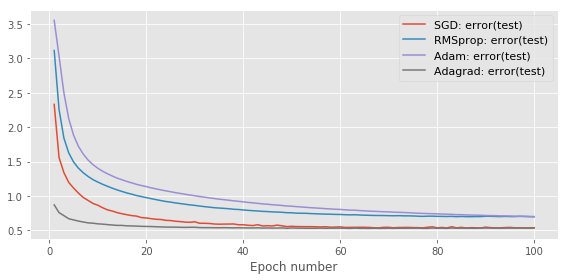

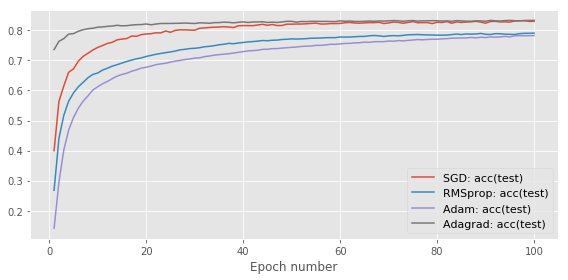

In [9]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(valid)']:
    ax_1.plot(np.arange(1, stats_1.shape[0]) * stats_interval, 
              stats_1[1:, keys_1[k]], label='SGD: error(test)')
    ax_1.plot(np.arange(1, stats_2.shape[0]) * stats_interval, 
              stats_2[1:, keys_2[k]], label='RMSprop: error(test)')
    ax_1.plot(np.arange(1, stats_3.shape[0]) * stats_interval, 
              stats_3[1:, keys_3[k]], label='Adam: error(test)')
    ax_1.plot(np.arange(1, stats_4.shape[0]) * stats_interval, 
              stats_4[1:, keys_4[k]], label='Adagrad: error(test)')
#     ax_1.legend(loc=0)
ax_1.grid('on') # Turn axes grid on
ax_1.legend(loc='best', fontsize=11) # Add a legend
ax_1.set_xlabel('Epoch number')

fig_1.tight_layout() # This minimises whitespace around the axes.
fig_1.savefig('full_err_test_models.pdf') # Save figure to current directory in PDF format

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(valid)']:
    ax_2.plot(np.arange(1, stats_1.shape[0]) * stats_interval, 
              stats_1[1:, keys_1[k]], label='SGD: acc(test)')
    ax_2.plot(np.arange(1, stats_2.shape[0]) * stats_interval, 
              stats_2[1:, keys_2[k]], label='RMSprop: acc(test)')
    ax_2.plot(np.arange(1, stats_3.shape[0]) * stats_interval, 
              stats_3[1:, keys_3[k]], label='Adam: acc(test)')
    ax_2.plot(np.arange(1, stats_4.shape[0]) * stats_interval, 
              stats_4[1:, keys_4[k]], label='Adagrad: acc(test)')
#     ax_2.legend(loc=0)
ax_2.grid('on') # Turn axes grid on
ax_2.legend(loc='best', fontsize=11) # Add a legend
ax_2.set_xlabel('Epoch number')

fig_2.tight_layout() # This minimises whitespace around the axes.
fig_2.savefig('full_acc_test_models.pdf') # Save figure to current directory in PDF format


plt.show()

In [15]:
np.arange(1, stats_1.shape[0]) * stats_interval

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [25]:
stats_4[1:, keys_4['acc(valid)']]

array([0.73601266, 0.76341772, 0.77259494, 0.78746835, 0.78917722,
       0.79708861, 0.8021519 , 0.80544304, 0.80721519, 0.81050633,
       0.81158228, 0.81335443, 0.81455696, 0.81689873, 0.815     ,
       0.81575949, 0.81765823, 0.81892405, 0.8193038 , 0.82126582,
       0.81860759, 0.82101266, 0.8228481 , 0.82291139, 0.82297468,
       0.82329114, 0.82367089, 0.82443038, 0.8235443 , 0.8228481 ,
       0.82512658, 0.82462025, 0.8235443 , 0.82563291, 0.82588608,
       0.82721519, 0.82664557, 0.82506329, 0.82670886, 0.82810127,
       0.82620253, 0.82778481, 0.82797468, 0.82873418, 0.82632911,
       0.82734177, 0.82626582, 0.82797468, 0.83006329, 0.83      ,
       0.82740506, 0.82955696, 0.82905063, 0.83006329, 0.83      ,
       0.82974684, 0.82987342, 0.82955696, 0.82911392, 0.83164557,
       0.83031646, 0.83107595, 0.82955696, 0.82962025, 0.83012658,
       0.83101266, 0.83031646, 0.83120253, 0.83082278, 0.83151899,
       0.83253165, 0.83196203, 0.83031646, 0.83170886, 0.83265

In [28]:
print (run_time_1 / 100.)
print (run_time_2 / 100.)
print (run_time_3 / 100.)
print (run_time_4 / 100.)

11.068403100967407
18.103679409027098
13.217312150001526
10.691857481002808


In [ ]:
learning_rates = [0.000001, 0.0000015, 0.00001, 0.000015]  # scale for random parameter initialisation
decay_rates_1 = [0.99, 0,999]#[0.85, 0.9, 0.95]
decay_rates_2 = [0.999]#[0.95, 0.975, 0.999]

for i, element in enumerate(product(learning_rates, decay_rates_1, decay_rates_2)):
    print(i, element[0], element[1], element[2])

In [ ]:
import numpy as np
from itertools import product
a = np.linspace(0.1, 0.9, 5) #np.array([1, 2, 3, 4, 5 , 6])
b = [0.000001, 0.0000015, 0.00001, 0.000015, 0.0001, 0.00015] #np.array(['a', 'b', 'c'])

for i, element in enumerate(product(a, b)):
    print(i, element)